## <a id='toc1_1_'></a>[Regresión Logística - Predicción de Supervivencia en el Titanic](#toc0_)

A continuación, se va a predecir la diabetes con un clasificador de regresión logística.

En primer lugar, cargamos el conjunto de datos necesario sobre la diabetes de los indios Pima (pima-indians-diabetes.csv) utilizando la función de lectura CSV de pandas.    

El conjunto de datos está accesible desde **datasets/pima-indians-diabetes.csv**.   

**Tabla de contenidos**<a id='toc0_'></a>    
- [Regresión Logística - Predicción de diabetes](#toc1_1_)    
  - [Carga de datos](#toc1_2_)    
  - [Seleccionar característica](#toc1_3_)    
  - [Dividir los datos](#toc1_4_)    
  - [Construcción, entrenamiento y predicción de modelos](#toc1_5_)    
  - [Evaluación del modelo mediante la matriz de confusión](#toc1_6_)    
  - [Visualización de la matriz de confusión mediante un mapa de calor (HEATMAP)](#toc1_7_)    
  - [Métricas de evaluación de la matriz de confusión](#toc1_8_)    
  - [Curva ROC](#toc1_9_)    
  - [Notas finales sobre el algoritmo de Regresión Logística.](#toc1_10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_2_'></a>[Carga de datos](#toc0_)

In [ ]:
#importamos pandas
import pandas as pd
import warnings
warnings.filterwarnings("ignore") #ignoramos los warnings


#cargamos  dataset
col_names_titanic_train = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic_train = pd.read_csv("datasets/titanic_train.csv", header=0, names=col_names_titanic_train)


#cargamos  dataset
col_names_titanic_test = ['PassengerId','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic_test = pd.read_csv("datasets/titanic_test.csv", header=0, names=col_names_titanic_test)
#cargamos  dataset
col_names_titanic_survived = ['PassengerId','Survived']
titanic_survived = pd.read_csv("datasets/gender_submission.csv", header=0, names=col_names_titanic_survived)






titanic_test_with_surived = pd.merge(titanic_survived, titanic_test, on='PassengerId', how='inner')


titanic_train_with_test_with_survived = pd.concat([titanic_train,titanic_test_with_surived])
titanic_ds=titanic_train_with_test_with_survived.dropna(subset=['Pclass', 'Sex', 'Age', 'SibSp','Parch','Fare','Embarked'])
titanic_ds.to_csv('titanic_cleaned.csv', index=False)

#sustituimos male a 0 y female a 1 
titanic_ds['Sex'] = titanic_ds['Sex'].replace({'male': 0, 'female': 1})

titanic_ds['Age'] = titanic_ds['Age'].replace({'NaN': titanic_ds['Age'].median()})


titanic_ds['FamilySize'] = titanic_ds['SibSp'] + titanic_ds['Parch']
titanic_ds['NameComplexity'] = titanic_ds['Name'].count

embarked_encoded = pd.get_dummies(titanic_ds['Embarked'], prefix='Embarked')
titanic_ds = pd.concat([titanic_ds, embarked_encoded], axis=1)
print(titanic_ds[['Embarked', 'Embarked_C', 'Embarked_Q', 'Embarked_S','NameComplexity']].head())
pri






  Embarked  Embarked_C  Embarked_Q  Embarked_S
0        S       False       False        True
1        C        True       False       False
2        S       False       False        True
3        S       False       False        True
4        S       False       False        True


In [390]:
titanic_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 415
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1043 non-null   int64  
 1   Survived     1043 non-null   int64  
 2   Pclass       1043 non-null   int64  
 3   Name         1043 non-null   object 
 4   Sex          1043 non-null   int64  
 5   Age          1043 non-null   float64
 6   SibSp        1043 non-null   int64  
 7   Parch        1043 non-null   int64  
 8   Ticket       1043 non-null   object 
 9   Fare         1043 non-null   float64
 10  Cabin        270 non-null    object 
 11  Embarked     1043 non-null   object 
 12  FamilySize   1043 non-null   int64  
 13  Embarked_C   1043 non-null   bool   
 14  Embarked_Q   1043 non-null   bool   
 15  Embarked_S   1043 non-null   bool   
dtypes: bool(3), float64(2), int64(7), object(4)
memory usage: 117.1+ KB


In [391]:
titanic_ds.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
FamilySize       int64
Embarked_C        bool
Embarked_Q        bool
Embarked_S        bool
dtype: object

In [392]:
titanic_ds.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,1,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,1,False,False,True
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,False,False,True


## <a id='toc1_3_'></a>[Seleccionar característica](#toc0_)

Dividimos las columnas dadas en dos tipos de variables: dependiente (o variable objetivo) e independiente (o variables características).

In [393]:
#split dataset (características y variable objetivo)
feature_cols = ['Pclass', 'Sex','Age', 'FamilySize','Fare','Embarked_C','Embarked_Q','Embarked_S']
X = titanic_ds[feature_cols] # características
y = titanic_ds.Survived # objetivo



## <a id='toc1_4_'></a>[Dividir los datos](#toc0_)

Dividimos el dataset en un conjunto de entrenamiento y un conjunto de prueba.

In [394]:
# split en train y test 75% - 25%
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

## <a id='toc1_5_'></a>[Construcción, entrenamiento y predicción de modelos](#toc0_)

1. Importamos el módulo Regresión logística.
2. Se crea un objeto clasificador de Regresión logística utilizando la función LogisticRegression() (con random_state fijado para repetir experimentos sin variación ).   
3. A continuación, entrenamos el modelo con fit() y finalmente, se lleva a cabo la predicción en el conjunto de prueba mediante predict(). 

In [395]:
# importamos el modelo
from sklearn.linear_model import LogisticRegression

# instanciamos el modelo (usando los parámetros por defecto)
logreg = LogisticRegression(random_state=16)

# entrenamos el modelo
logreg.fit(X_train, y_train)

# hacemos predicciones sobre el conjunto de test
y_pred = logreg.predict(X_test)

## <a id='toc1_6_'></a>[Evaluación del modelo mediante la matriz de confusión](#toc0_)

Una matriz de confusión es una tabla que se utiliza para evaluar el rendimiento de un modelo de clasificación.       
La información de una matriz de confusión es el número de predicciones correctas e incorrectas sumadas por clases.

In [396]:
# importamos la clase de métricas
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[141,  17],
       [ 22,  81]])

Aquí puedes ver la matriz de confusión en forma de array.   
La dimensión de esta matriz es 2*2 porque este modelo es de clasificación binaria.   
Tienes dos clases 0 y 1.   
Los valores diagonales representan predicciones exactas, mientras que los elementos no diagonales son predicciones inexactas.   
En la salida, 115 y 42 son predicciones reales, y 25 y 10 son predicciones incorrectas. (Ojo, puede variar en función de la versión de la librería por temas de precisión)

## <a id='toc1_7_'></a>[Visualización de la matriz de confusión mediante un mapa de calor (HEATMAP)](#toc0_)

Vamos a visualizar los resultados del modelo en forma de matriz de confusión utilizando matplotlib y seaborn.

A continuación se visualiza la matriz de confusión utilizando Heatmap.

Text(0.5, 427.9555555555555, 'Predicted label')

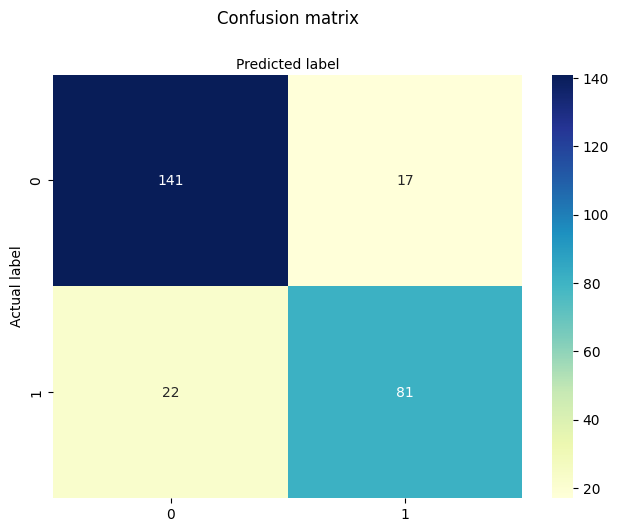

In [397]:

# importamos los módulos necesarios
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # nombre de las clases
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# creamos el heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


## <a id='toc1_8_'></a>[Métricas de evaluación de la matriz de confusión](#toc0_)

Vamos a evaluar el modelo utilizando *classification_report* para ver la exactitud, la precisión y la recuperación/sensibilidad/recall.

In [398]:
from sklearn.metrics import classification_report
target_names = ['Muerto', 'Vivo']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Muerto       0.87      0.89      0.88       158
        Vivo       0.83      0.79      0.81       103

    accuracy                           0.85       261
   macro avg       0.85      0.84      0.84       261
weighted avg       0.85      0.85      0.85       261



Se ha obtenido un índice de clasificación del 82 %, lo que se considera una buena precisión.

- Precisión: La precisión consiste en ser preciso, es decir, lo exacto que es el modelo. En otras palabras, se puede decir, cuando un modelo hace una predicción, con qué frecuencia acierta. En este caso de predicción, cuando el modelo de Regresión Logística predijo que los pacientes iban a padecer diabetes, ese 81 % de las veces, mientras que para el caso de aquellos que no la padecerán acierta el 82 % de las ocasiones.

- Sensibilidad/Recall: Si hay pacientes que tienen diabetes en el conjunto de pruebas y tu modelo de regresión logística puede identificarla el 63 % de las veces.
- Exactitud/Accuracy: 82 %. Recordamos que es la proporción de todas las clasificaciones correctas, ya sean positivas o negativas.

## <a id='toc1_9_'></a>[Curva ROC](#toc0_)

Introducimos una nueva métrica, denominada curva ROC (característica operativa del receptor), que es un gráfico que muestra la tasa de verdaderos positivos frente a la tasa de falsos positivos.    
Nos ofrece el compromiso entre sensibilidad y especificidad.

***La especificidad («Specificity»)***   
También conocida como la Tasa de Verdaderos Negativos, (“true negative rate”) o TN. Se trata de los casos negativos que el algoritmo ha clasificado correctamente.  Expresa cuan bien puede el modelo detectar esa clase.
Se calcula:  **VN/(VN+FP)**

In [399]:
from sklearn.metrics import recall_score
# specificity
# specificity = TN / (TN + FP) 
# La especificidad se calcula como el recall de la clase 0

especificidad = recall_score(y_test, y_pred, pos_label=0) * 100
print("Especificidad: ", especificidad, "%")

Especificidad:  89.24050632911393 %


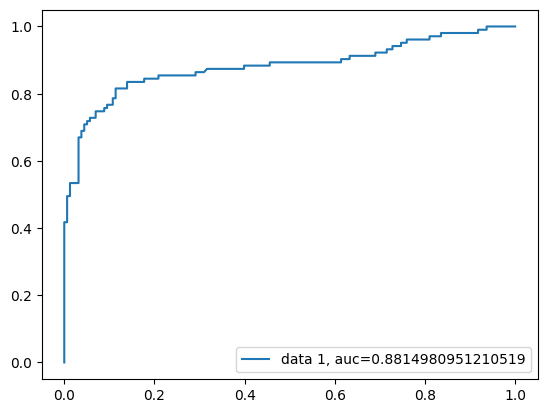

In [400]:
# Curva ROC
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

La puntuación AUC del modelo es de 0,88.   
La puntuación AUC 1 representa un clasificador perfecto, y desde 0,5 hacia 0 representa un clasificador que no funciona adecuadamente.

## <a id='toc1_10_'></a>[Notas finales sobre el algoritmo de Regresión Logística.](#toc0_)

- Ventajas
  - No requiere una gran potencia de cálculo-
  - Es fácil de aplicar
  - Es fácilmente interpretable 
  - No requiere escalado de funciones. 

- Desventajas
 - La regresión logística no es capaz de manejar un gran número de características/variables categóricas. 
 - Es vulnerable al sobreajuste. 
 - No se puede resolver un problema no lineal con la regresión logística. 
 - La regresión logística no funcionará bien con variables independientes que no estén correlacionadas con la variable objetivo y sean muy similares o estén correlacionadas entre sí.